In [1]:
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from astropy.io import ascii
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
#from astropy.cosmology import Planck18 as cosmo
import pandas as pd
import pprint
import sys
import operator
from scipy import optimize
from scipy import stats
from scipy.optimize import curve_fit
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=71, Om0=0.27)
import seaborn as sbrn
from scipy.spatial.distance import cdist, euclidean
import cmastro.cm as cma
from lmfit import minimize, Parameters
plt.rcParams['figure.figsize'] = (12,10)
plt.rcParams['figure.dpi'] = 400

In [63]:
data = ascii.read("prospector_UVJ_galfit_FAST_ERRCORR2.csv", format='csv')
columns = pd.read_csv('prospector_UVJ_galfit_FAST_ERRCORR2.csv', index_col=0, nrows=0).columns.tolist()
print(data)

 col0  objname   f  f_f125w ... avg_age_errup avg_age_errdown   q        dq   
----- --------- --- ------- ... ------------- --------------- ------ ---------
    0  AEGIS_13 0.0     1.0 ...        2.6073          2.0686  0.486 0.0127806
    1  AEGIS_17 0.0     1.0 ...        1.5864          0.9056   0.73 0.0504242
    2  AEGIS_19 0.0     0.0 ...        2.8717          1.6812 0.5641 0.0324193
    3  AEGIS_22 0.0     0.0 ...        2.2839          1.2629 0.5383  0.204531
    4  AEGIS_23 0.0     2.0 ...        2.8804          0.9751 0.4658  0.228026
    5  AEGIS_24 0.0     2.0 ...        2.1962          0.7102 0.3485   0.14098
    6  AEGIS_27 2.0     0.0 ...        4.1165          3.3712 0.3555 0.0246928
  ...       ... ...     ... ...           ...             ...    ...       ...
63406 UDS_44064 0.0     2.0 ...        3.2167          1.9035 0.2308   0.56633
63407 UDS_44074 2.0     1.0 ...        2.1848          1.3021 0.3244 0.0989317
63408 UDS_44077 1.0     0.0 ...        2.9466       

In [64]:
#data from csv
redshift_data = data['z']
lmass_data = data['logstellar_mass_median']
lmass_errup_data = -data['logstellar_mass_median']+data['logstellar_mass_errup']
lmass_errdn_data = data['logstellar_mass_median']-data['logstellar_mass_errdown']
ssfr_data = data['logssfr_100myr_median']
ssfr_errup_data = -data['logssfr_100myr_median']+data['logssfr_100myr_errup']
ssfr_errdn_data = data['logssfr_100myr_median']-data['logssfr_100myr_errdown']
f125w_radius_data = data['re_f125w']
f160w_radius_data = data['re']
f125w_radius_err_data = data['dre_f125w']
f160w_radius_err_data = data['dre']
UVcol_data = data['UV']
VJcol_data = data['VJ']
f125w_flags = data['f_f125w']
f160w_flags = data['f']
FAST_lmass_data = data['FAST_lmass']
f125w_mag_data = data['mag_f125w']
f160w_mag_data = data['mag_f160w']


arcrad_5000 = []
arcrad_5000_err = []
flags = []

#convert observed angular size to 5000A rest-frame size
for i, z in enumerate(redshift_data):
    if z<=1.5:
        arcrad_5000.append(f125w_radius_data[i]*((1+z)/(1+1.5))**(-0.35+0.12*z-0.25*(lmass_data[i]/10)))
        arcrad_5000_err.append(f125w_radius_err_data[i]*((1+z)/(1+1.5))**(-0.35+0.12*z-0.25*(lmass_data[i]/10)))
        flags.append(f125w_flags[i])
    else:
        arcrad_5000.append(f160w_radius_data[i]*((1+z)/(1+2.2))**(-0.35+0.12*z-0.25*(lmass_data[i]/10)))
        arcrad_5000_err.append(f160w_radius_err_data[i]*((1+z)/(1+2.2))**(-0.35+0.12*z-0.25*(lmass_data[i]/10)))
        flags.append(f160w_flags[i])
        
#conversion to numpy arrays
flags = np.asarray(flags)
R_eff_arc = np.asarray(arcrad_5000)
R_eff_arc_err = np.asarray(arcrad_5000_err)

#constraining data using flags from vdW paper
constraints = (flags<=1.0) & (FAST_lmass_data>=9)
redshift = redshift_data[constraints]
FAST_lmass = np.asarray(FAST_lmass_data[constraints])
lmass = lmass_data[constraints]
lmass_errup = lmass_errup_data[constraints]
lmass_errdn = lmass_errdn_data[constraints]
lssfr = ssfr_data[constraints]
R_eff_arc = R_eff_arc[constraints]
R_eff_arc_err = R_eff_arc_err[constraints]
UVcol = UVcol_data[constraints]
VJcol = VJcol_data[constraints]
f125w_mag = f125w_mag_data[constraints]
f160w_mag = f160w_mag_data[constraints]
#print(R_eff_arc_err)

#convert angular size to physical size
arc_to_kpc = cosmo.kpc_proper_per_arcmin(redshift)/60
R_eff = (R_eff_arc*arc_to_kpc).value
R_eff_err = (R_eff_arc_err*arc_to_kpc).value
lR_eff = np.log10(R_eff)
lR_eff_err = 0.434*(R_eff_err/R_eff)

#starforming and quiescent selections
starforming = ((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))
quiescent = (UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))

#50% completeness selections
bin2_50_sf = (lmass>9.29)
bin3_50_sf = (lmass>9.5)
bin4_50_sf = (lmass>9.63)
bin1_50_q = (lmass>9.2)
bin2_50_q = (lmass>9.67)
bin3_50_q = (lmass>9.9)
bin4_50_q1 = (lmass>10.33)

#80% completeness selections
bin1_80_sf = (lmass>9.2)
bin2_80_sf = (lmass>9.46)
bin3_80_sf = (lmass>9.75)
bin4_80_sf = (lmass>10)
bin1_80_q = (lmass>9.36)
bin2_80_q = (lmass>9.87)
bin3_80_q = (lmass>10.06)
bin4_80_q1 = (lmass>10.65)

print(len(lR_eff))

34488


In [65]:
#data creation
FAST_q = []
FAST_q_vdw = []
R_q = []
R_q_err = []
R_q_vdw = []
R_q_vdw_err = []

M_q = []
mag_q = []

FAST_sf = []
FAST_sf_vdw = []
R_sf = []
R_sf_err = []
R_sf_vdw = []
R_sf_vdw_err = []

M_sf = []
mag_sf = []

#quiescent prospector data
M_q.append(lmass[(redshift>=0.5)&(redshift<=1.0)&(quiescent)])
M_q.append(lmass[(redshift>1.0)&(redshift<=1.5)&(quiescent)])
M_q.append(lmass[(redshift>1.5)&(redshift<=2.0)&(quiescent)])
M_q.append(lmass[(redshift>2.0)&(quiescent)])

# quiescent fast data
FAST_q.append(FAST_lmass[(redshift<=1.0)&(quiescent)])
FAST_q.append(FAST_lmass[(redshift>1.0)&(redshift<=1.5)&(quiescent)])
FAST_q.append(FAST_lmass[(redshift>1.5)&(redshift<=2.0)&(quiescent)])
FAST_q.append(FAST_lmass[(redshift>2.0)&(quiescent)])

#quiescent radius data
R_q.append(lR_eff[(redshift<=1.0)&(quiescent)])
R_q.append(lR_eff[(redshift>1.0)&(redshift<=1.5)&(quiescent)])
R_q.append(lR_eff[(redshift>1.5)&(redshift<=2.0)&(quiescent)])
R_q.append(lR_eff[(redshift>2)&(quiescent)])

#error on quiescent radius data
R_q_err.append(lR_eff_err[(redshift<=1.0)&(quiescent)])
R_q_err.append(lR_eff_err[(redshift>1.0)&(redshift<=1.5)&(quiescent)])
R_q_err.append(lR_eff_err[(redshift>1.5)&(redshift<=2.0)&(quiescent)])
R_q_err.append(lR_eff_err[(redshift>2.0)&(quiescent)])

#quiescent f160w magnitude data
mag_q.append(f160w_mag[(redshift>=0.5)&(redshift<=1.0)&(quiescent)])
mag_q.append(f160w_mag[(redshift>1.0)&(redshift<=1.5)&(quiescent)])
mag_q.append(f160w_mag[(redshift>1.5)&(redshift<=2.0)&(quiescent)])
mag_q.append(f160w_mag[(redshift>2.0)&(quiescent)])

#quiescent fast data over M=10.3 following vdw
FAST_q_vdw.append(FAST_lmass[(redshift<=1.0)&(quiescent)&(FAST_lmass>10.301)])
FAST_q_vdw.append(FAST_lmass[(redshift>1.0)&(redshift<=1.5)&(quiescent)&(FAST_lmass>10.301)])
FAST_q_vdw.append(FAST_lmass[(redshift>1.5)&(redshift<=2.0)&(quiescent)&(FAST_lmass>10.301)])
FAST_q_vdw.append(FAST_lmass[(redshift>2.0)&(quiescent)&(FAST_lmass>10.301)])

#quiescent radius data over M=10.3 from vdw
R_q_vdw.append(lR_eff[(redshift<=1.0)&(quiescent)&(FAST_lmass>10.301)])
R_q_vdw.append(lR_eff[(redshift>1.0)&(redshift<=1.5)&(quiescent)&(FAST_lmass>10.301)])
R_q_vdw.append(lR_eff[(redshift>1.5)&(redshift<=2.0)&(quiescent)&(FAST_lmass>10.301)])
R_q_vdw.append(lR_eff[(redshift>2.0)&(quiescent)&(FAST_lmass>10.301)])

#error on quiescent radius data over M=10.3 from vdw
R_q_vdw_err.append(lR_eff_err[(redshift<=1.0)&(quiescent)&(FAST_lmass>10.301)])
R_q_vdw_err.append(lR_eff_err[(redshift>1.0)&(redshift<=1.5)&(quiescent)&(FAST_lmass>10.301)])
R_q_vdw_err.append(lR_eff_err[(redshift>1.5)&(redshift<=2.0)&(quiescent)&(FAST_lmass>10.301)])
R_q_vdw_err.append(lR_eff_err[(redshift>2.0)&(quiescent)&(FAST_lmass>10.301)])

#prospector starforming data
M_sf.append(lmass[(redshift>=0.5)&(redshift<=1.0)&(starforming)])
M_sf.append(lmass[(redshift>1.0)&(redshift<=1.5)&(starforming)])
M_sf.append(lmass[(redshift>1.5)&(redshift<=2.0)&(starforming)])
M_sf.append(lmass[(redshift>2.0)&(starforming)])

#fast starforming data
FAST_sf.append(FAST_lmass[(redshift<=1.0)&(starforming)])
FAST_sf.append(FAST_lmass[(redshift>1.0)&(redshift<=1.5)&(starforming)])
FAST_sf.append(FAST_lmass[(redshift>1.5)&(redshift<=2.0)&(starforming)])
FAST_sf.append(FAST_lmass[(redshift>2.0)&(starforming)])

#starforming radius data
R_sf.append(lR_eff[(redshift<=1.0)&(starforming)])
R_sf.append(lR_eff[(redshift>1.0)&(redshift<=1.5)&(starforming)])
R_sf.append(lR_eff[(redshift>1.5)&(redshift<=2.0)&(starforming)])
R_sf.append(lR_eff[(redshift>2)&(starforming)])

#error on quiescent radius data
R_sf_err.append(lR_eff_err[(redshift<=1.0)&(starforming)])
R_sf_err.append(lR_eff_err[(redshift>1.0)&(redshift<=1.5)&(starforming)])
R_sf_err.append(lR_eff_err[(redshift>1.5)&(redshift<=2.0)&(starforming)])
R_sf_err.append(lR_eff_err[(redshift>2.0)&(starforming)])

#starforming f160w magnitudes
mag_sf.append(f160w_mag[(redshift>=0.5)&(redshift<=1.0)&(starforming)])
mag_sf.append(f160w_mag[(redshift>1.0)&(redshift<=1.5)&(starforming)])
mag_sf.append(f160w_mag[(redshift>1.5)&(redshift<=2.0)&(starforming)])
mag_sf.append(f160w_mag[(redshift>2.0)&(starforming)])

#fast starforming data over M=10.3 from vdw
FAST_sf_vdw.append(FAST_lmass[(redshift<=1.0)&(starforming)&(FAST_lmass>10.301)])
FAST_sf_vdw.append(FAST_lmass[(redshift>1.0)&(redshift<=1.5)&(starforming)&(FAST_lmass>10.301)])
FAST_sf_vdw.append(FAST_lmass[(redshift>1.5)&(redshift<=2.0)&(starforming)&(FAST_lmass>10.301)])
FAST_sf_vdw.append(FAST_lmass[(redshift>2.0)&(starforming)&(FAST_lmass>10.301)])

#starforming radius data over M=10.3 from vdw
R_sf_vdw.append(lR_eff[(redshift<=1.0)&(starforming)&(FAST_lmass>10.301)])
R_sf_vdw.append(lR_eff[(redshift>1.0)&(redshift<=1.5)&(starforming)&(FAST_lmass>10.301)])
R_sf_vdw.append(lR_eff[(redshift>1.5)&(redshift<=2.0)&(starforming)&(FAST_lmass>10.301)])
R_sf_vdw.append(lR_eff[(redshift>2.0)&(starforming)&(FAST_lmass>10.301)])

#error on starforming radius data over M=10.3 from vdw
R_sf_vdw_err.append(lR_eff_err[(redshift<=1.0)&(starforming)&(FAST_lmass>10.301)])
R_sf_vdw_err.append(lR_eff_err[(redshift>1.0)&(redshift<=1.5)&(starforming)&(FAST_lmass>10.301)])
R_sf_vdw_err.append(lR_eff_err[(redshift>1.5)&(redshift<=2.0)&(starforming)&(FAST_lmass>10.301)])
R_sf_vdw_err.append(lR_eff_err[(redshift>2.0)&(starforming)&(FAST_lmass>10.301)])

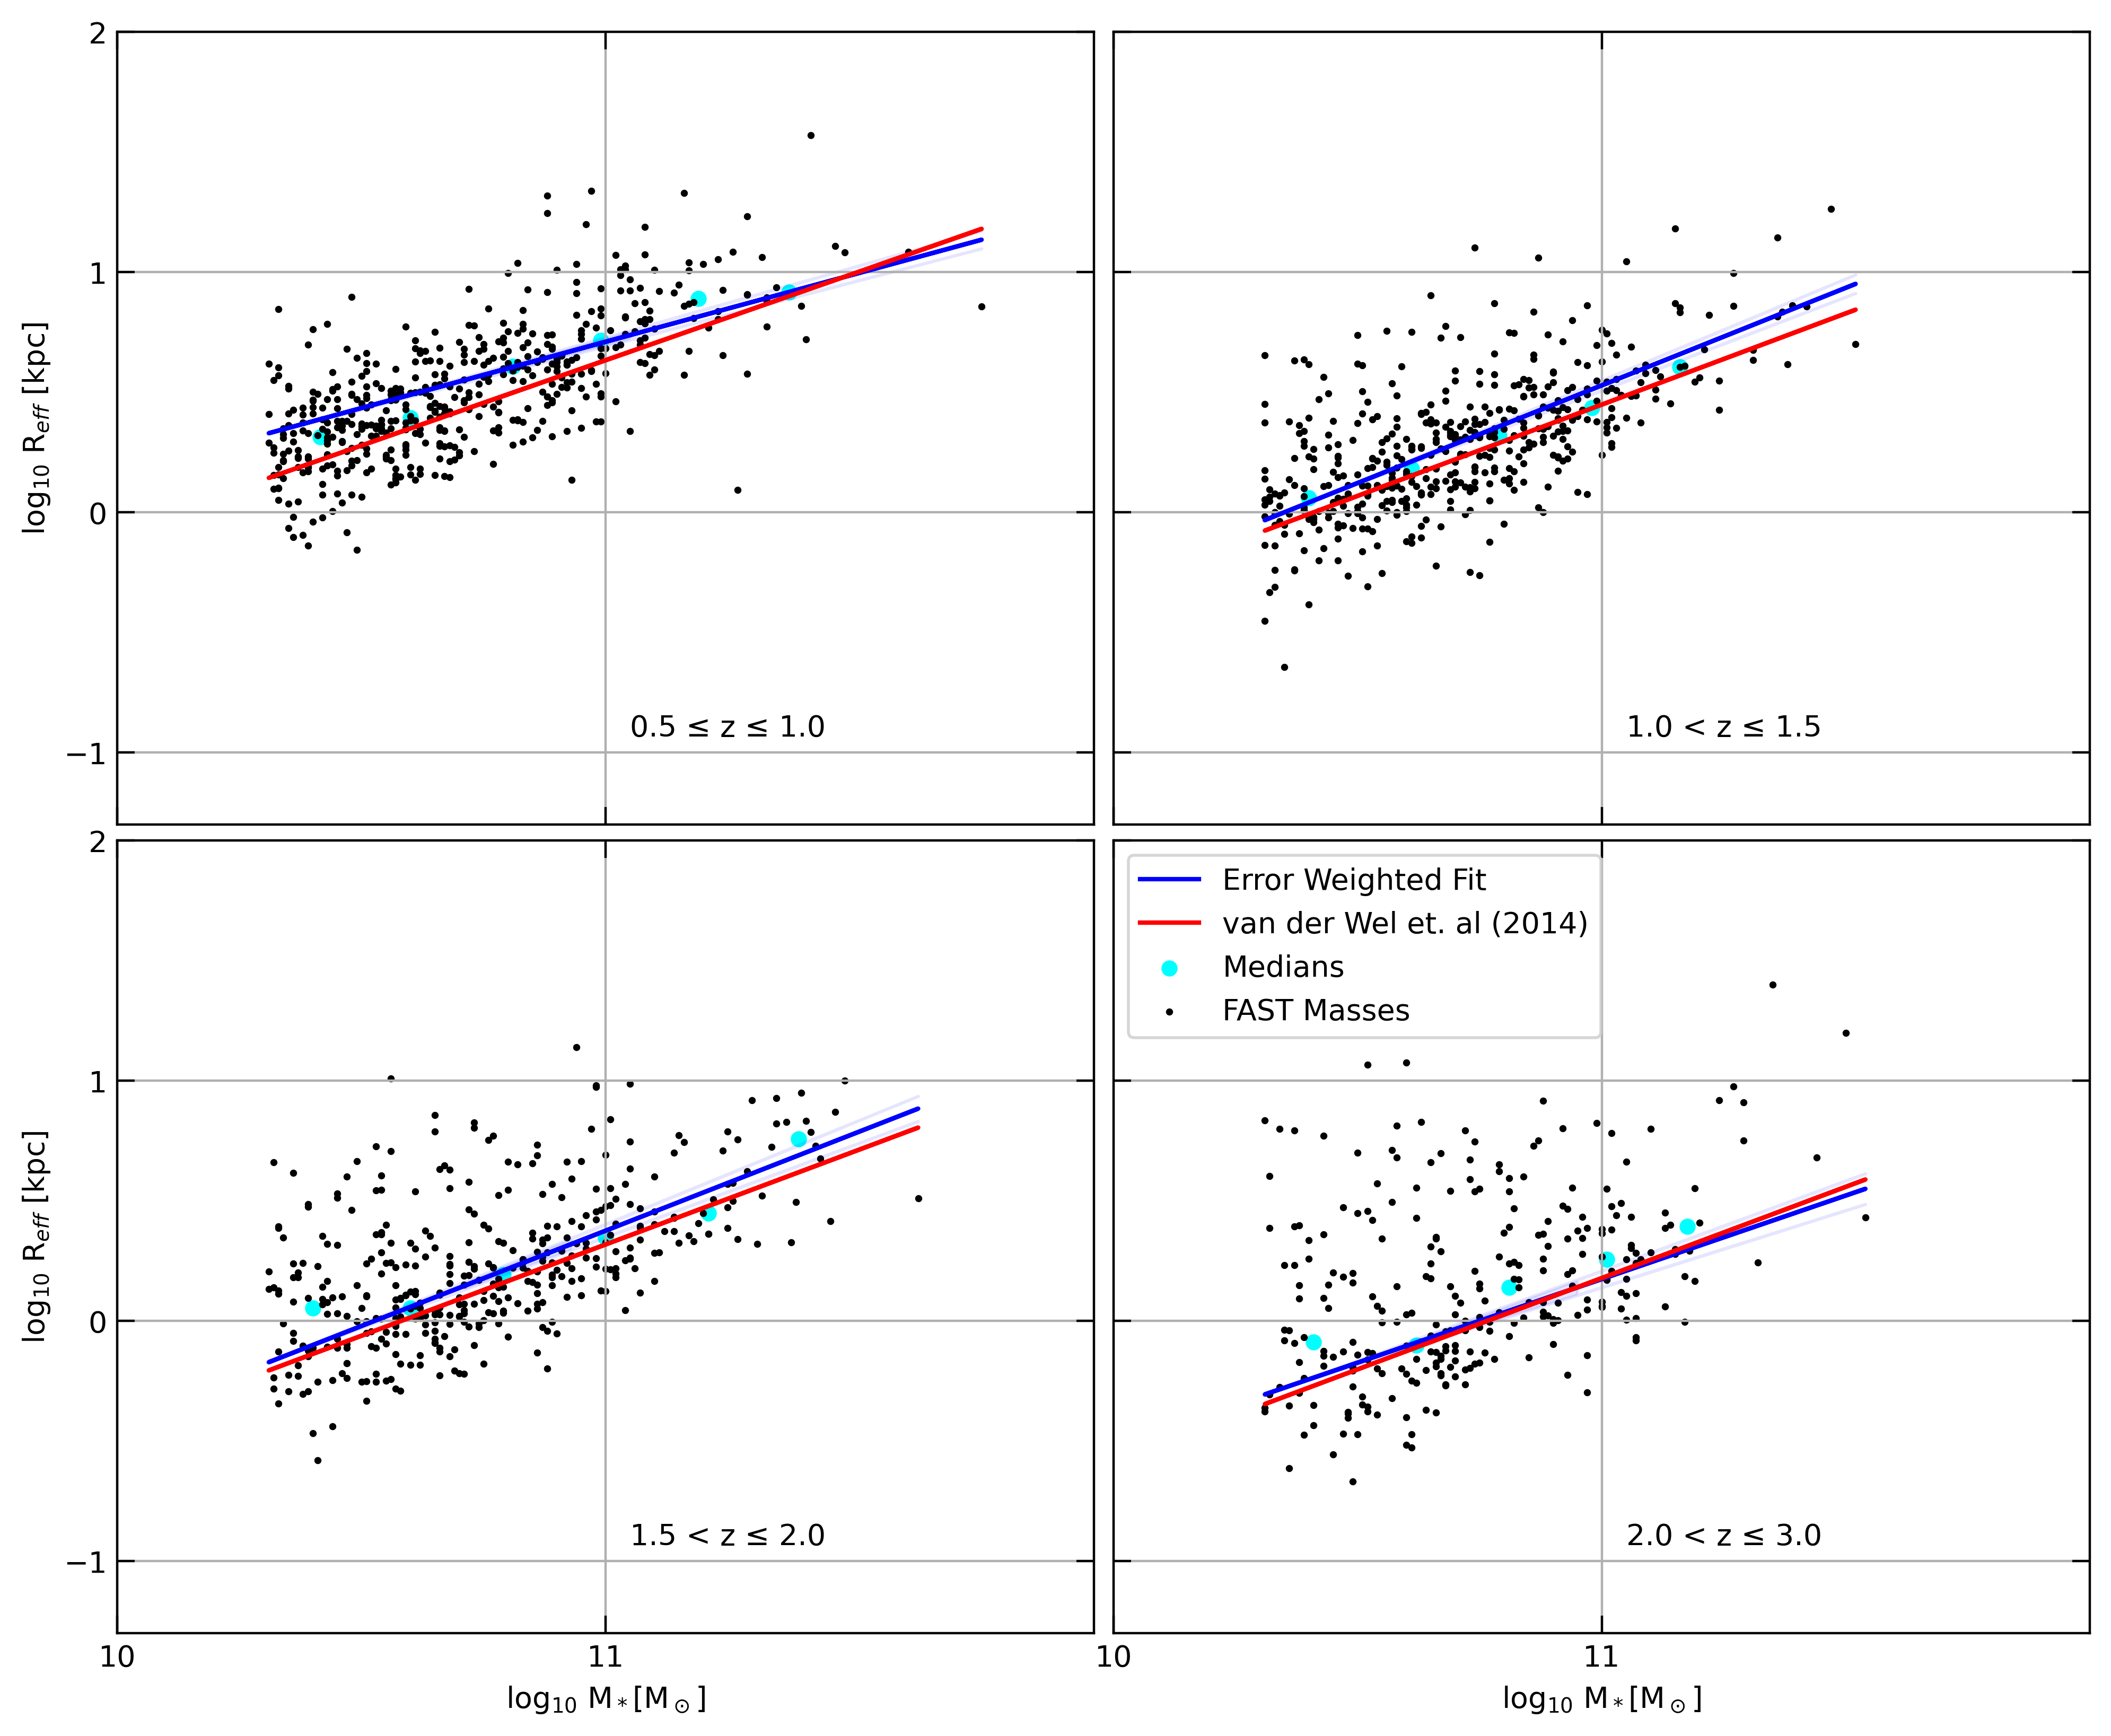

In [32]:
def power_law(M,A,a):
    return A+(a*M-a*np.log10(5e10))

def broken_power_law(lmass,A1,alpha1,alpha2,mp):
    mstar=(10**lmass)/5e10
    mpstar=(10**mp)/5e10
    A2=A1*mpstar**(alpha1-alpha2)
    out=np.zeros_like(lmass)
    out[lmass<=mp]=A1*mstar[lmass<=mp]**alpha1
    out[lmass>mp]=A2*mstar[lmass>mp]**alpha2
    return out

def quiescent_fit(xvals, yvals, error):   #curve fit calculation with upper fit and lower fit and comparison line
    fit_q.append(curve_fit(f=power_law, xdata=xvals, ydata=yvals, sigma=error, p0=x0, bounds=bounds))
    highfit_q.append(fit_q[z][0]+np.sqrt(np.diag(fit_q[z][1])))
    lowfit_q.append(fit_q[z][0]-np.sqrt(np.diag(fit_q[z][1])))
    R_q_fit.append(power_law(xvals,*fit_q[z][0]))
    R_q_comp.append(power_law(FAST_q_vdw[z],Acomp[z],acomp[z]))
    R_q_low.append(power_law(xvals,*lowfit_q[z]))
    R_q_high.append(power_law(xvals,*highfit_q[z]))


#median calculation based on binsize and selection threshold
marray=np.arange(7.5,13,0.2)
M_medians = []
R_medians = []
R_medians_err = []

for z in range(4):
    mass_med = []
    radius_med = []
    radius_med_err = []
    for m in marray:
        sel=(FAST_q_vdw[z]>m)&(FAST_q_vdw[z]<m+0.2)    #mass selection
        #print(z,sum(sel))
        if sum(sel)>=10:
            mass_med.append(np.median(FAST_q_vdw[z][sel]))  #adding mass medians for each selection
            radius_med.append(np.median(R_q_vdw[z][sel]))   #adding radius medians for each selection
    mass_med = [i for i in mass_med if np.isnan(i) == False]  #removing nan values from median array
    mass_med = np.asarray(mass_med,dtype=object)
    radius_med = [i for i in radius_med if np.isnan(i) == False]  #removing nan values from median array
    radius_med = np.asarray(radius_med,dtype=object)
    M_medians.append(mass_med)
    R_medians.append(radius_med)
M_medians = np.asarray(M_medians,dtype=object)
R_medians = np.asarray(R_medians,dtype=object)
M_medians = [a.astype(np.float64) for a in M_medians]
R_medians = [a.astype(np.float64) for a in R_medians]

x0 =[0.3,0.75] #inital values of fit
bounds = ([-10,-10],[10,10]) #bounds of fit


#arrays in which the outputs of the fitting code will be sent
fit_q = []
highfit_q = []
lowfit_q = []
R_q_fit = []
R_q_comp = []
R_q_low = []
R_q_high = []

Acomp = [0.42,0.22,0.09,-0.05]  #A parameters from vdW
acomp = [0.71,0.76,0.76,0.76]  #alpha prameters from vdW

#fitting data
for z in range(4):
    #quiescent_fit(M_medians[z], R_medians[z], None)   #median weighted fit
    quiescent_fit(FAST_q_vdw[z], R_q_vdw[z], R_q_vdw_err[z])  #error weighted fit

#plotting data
x = [0,0,1,1]
y = [0,1,0,1]
zlabels = ['0.5 ≤ z ≤ 1.0','1.0 < z ≤ 1.5','1.5 < z ≤ 2.0','2.0 < z ≤ 3.0']

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

for z in range(4):
    ax[x[z],y[z]].scatter(M_medians[z],R_medians[z],s=20,c='cyan', label='Medians')
    ax[x[z],y[z]].scatter(FAST_q_vdw[z],R_q_vdw[z],s=2,c='black',label='FAST Masses')
    ax[x[z],y[z]].plot(FAST_q_vdw[z],R_q_fit[z],c='blue',label='Error Weighted Fit')
    ax[x[z],y[z]].plot(FAST_q_vdw[z],R_q_comp[z],'',c='red',label='van der Wel et. al (2014)')
    ax[x[z],y[z]].fill_between(FAST_q_vdw[z],R_q_low[z],R_q_high[z],color='blue',alpha=0.1)
    ax[x[z],y[z]].tick_params(which='major', direction='in', length=6)
    ax[x[z],y[z]].tick_params(which='minor', direction='in')
    if z == 0 or z == 2:
        ax[x[z],y[z]].set_yticks([-1,0,1,2])
    else:
        ax[x[z],y[z]].set_xticks([8,9,10,11])
    ax[x[z],y[z]].xaxis.set_ticks_position('both')
    ax[x[z],y[z]].yaxis.set_ticks_position('both')
    ax[x[z],y[z]].set_xlim(10,12)
    ax[x[z],y[z]].set_ylim(-1.3,2)
    ax[x[z],y[z]].text(11.05,-0.93,zlabels[z])
    if z==2 or z==3:
        ax[x[z],y[z]].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
    if z==0 or z==2:
        ax[x[z],y[z]].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')
    ax[x[z],y[z]].grid(True,'minor',alpha=0.1)
    ax[x[z],y[z]].grid()
    if z == 3:
        ax[x[z],y[z]].legend()

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

In [44]:
def power_law(M,A,a):
    return A+(a*M-a*np.log10(5e10))

def broken_power_law(lmass,A1,alpha1,alpha2,mp):
    mstar=(10**lmass)/5e10
    mpstar=(10**mp)/5e10
    A2=A1*mpstar**(alpha1-alpha2)
    out=np.zeros_like(lmass)
    out[lmass<=mp]=A1*mstar[lmass<=mp]**alpha1
    out[lmass>mp]=A2*mstar[lmass>mp]**alpha2
    return out

def broken_quiescent_fit(xvals, yvals, error):   #curve fit calculation with upper fit and lower fit and comparison line
    broken_fit_q.append(curve_fit(f=broken_power_law, xdata=xvals, ydata=yvals, sigma=error, p0=x0sam, bounds=boundssam))
    broken_highfit_q.append(broken_fit_q[z][0]+np.sqrt(np.diag(broken_fit_q[z][1])))
    broken_lowfit_q.append(broken_fit_q[z][0]-np.sqrt(np.diag(broken_fit_q[z][1])))
    R_q_broken_fit.append(broken_power_law(xvals,*broken_fit_q[z][0]))
    R_q_broken_comp.append(broken_power_law(M_q[z],Asam[z],a1sam[z],a2sam[z],mp[z]))
    R_q_broken_low.append(broken_power_law(xvals,*broken_lowfit_q[z]))
    R_q_broken_high.append(broken_power_law(xvals,*broken_highfit_q[z]))
    
def quiescent_fit(xvals, yvals, error):   #curve fit calculation with upper fit and lower fit and comparison line
    fit_q.append(curve_fit(f=power_law, xdata=xvals, ydata=yvals, sigma=error, p0=x0vdw, bounds=boundsvdw))
    highfit_q.append(fit_q[z][0]+np.sqrt(np.diag(fit_q[z][1])))
    lowfit_q.append(fit_q[z][0]-np.sqrt(np.diag(fit_q[z][1])))
    R_q_fit.append(power_law(xvals,*fit_q[z][0]))
    R_q_comp.append(power_law(M_q[z],Acomp[z],acomp[z]))
    R_q_low.append(power_law(xvals,*lowfit_q[z]))
    R_q_high.append(power_law(xvals,*highfit_q[z]))


#median calculation based on binsize and selection threshold
marray=np.arange(7.5,13,0.2)
M_medians = []
R_medians = []
R_medians_err = []

for z in range(4):
    mass_med = []
    radius_med = []
    radius_med_err = []
    for m in marray:
        sel=(M_q[z]>m)&(M_q[z]<m+0.2)    #mass selection
        #print(z,sum(sel))
        if sum(sel)>=10:
            mass_med.append(np.median(M_q[z][sel]))  #adding mass medians for each selection
            radius_med.append(np.median(R_q[z][sel]))   #adding radius medians for each selection
    mass_med = [i for i in mass_med if np.isnan(i) == False]  #removing nan values from median array
    mass_med = np.asarray(mass_med,dtype=object)
    radius_med = [i for i in radius_med if np.isnan(i) == False]  #removing nan values from median array
    radius_med = np.asarray(radius_med,dtype=object)
    M_medians.append(mass_med)
    R_medians.append(radius_med)
M_medians = np.asarray(M_medians,dtype=object)
R_medians = np.asarray(R_medians,dtype=object)
M_medians = [a.astype(np.float64) for a in M_medians]
R_medians = [a.astype(np.float64) for a in R_medians]


x0vdw =[0.3,0.75] #inital values of fit
boundsvdw = ([-10,-10],[10,10]) #bounds of fit
x0sam =[1.5,0.01, 0.47, 10.4] #inital values of fit
boundssam = ([-10,-10,-10,9],[10,10,10,11]) #bounds of fit


#arrays in which the outputs of the fitting code will be sent
fit_q = []
highfit_q = []
lowfit_q = []
R_q_fit = []
R_q_comp = []
R_q_low = []
R_q_high = []
broken_fit_q = []
broken_highfit_q = []
broken_lowfit_q = []
R_q_broken_fit = []
R_q_broken_comp = []
R_q_broken_low = []
R_q_broken_high = []

Avdw = [0.42,0.22,0.09,-0.05]  #A parameters from vdW
avdw = [0.71,0.76,0.76,0.76]

Asam = [1.73,1.23]  #A parameters from vdW
a1sam = [0.04,-0.01]
a2sam = [0.45,0.50]
mp = [10.37,10.50]

#fitting data
for z in range(4):
    #quiescent_fit(M_medians[z], R_medians[z], None)   #median weighted fit
    if z < 2:
        broken_quiescent_fit(M_q[z], R_q[z], R_q_err[z])   #error weighted fit
    else:
        quiescent_fit(M_q[z], R_q[z], R_q_err[z])

#plotting data
x = [0,0,1,1]
y = [0,1,0,1]
zlabels = ['0.5 ≤ z ≤ 1.0','1.0 < z ≤ 1.5','1.5 < z ≤ 2.0','2.0 < z ≤ 3.0']

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

for z in range(4):
    ax[x[z],y[z]].scatter(M_medians[z],R_medians[z],s=20,c='cyan', label='Medians')
    ax[x[z],y[z]].scatter(M_q[z],R_q[z],s=2,c='grey',label='M Masses')
    ax[x[z],y[z]].plot(M_q[z],R_q_fit[z],c='blue',label='Error Weighted Fit')
    ax[x[z],y[z]].plot(M_q[z],R_q_broken_fit[z],c='green',label='Error Weighted Fit')
    ax[x[z],y[z]].plot(M_q[z],R_q_comp[z],'',c='red',label='van der Wel et. al (2014)')
    ax[x[z],y[z]].fill_between(M_q[z],R_q_low[z],R_q_high[z],color='blue',alpha=0.1)
    ax[x[z],y[z]].tick_params(which='major', direction='in', length=6)
    ax[x[z],y[z]].tick_params(which='minor', direction='in')
    if z == 0 or z == 2:
        ax[x[z],y[z]].set_yticks([-1,0,1,2])
    else:
        ax[x[z],y[z]].set_xticks([8,9,10,11])
    ax[x[z],y[z]].xaxis.set_ticks_position('both')
    ax[x[z],y[z]].yaxis.set_ticks_position('both')
    #ax[x[z],y[z]].set_xlim(10,12)
    #ax[x[z],y[z]].set_ylim(-1.3,2)
    ax[x[z],y[z]].text(11.05,-0.93,zlabels[z])
    if z==2 or z==3:
        ax[x[z],y[z]].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
    if z==0 or z==2:
        ax[x[z],y[z]].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')
    ax[x[z],y[z]].grid(True,'minor',alpha=0.1)
    ax[x[z],y[z]].grid()
    if z == 3:
        ax[x[z],y[z]].legend()

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

IndexError: list index out of range

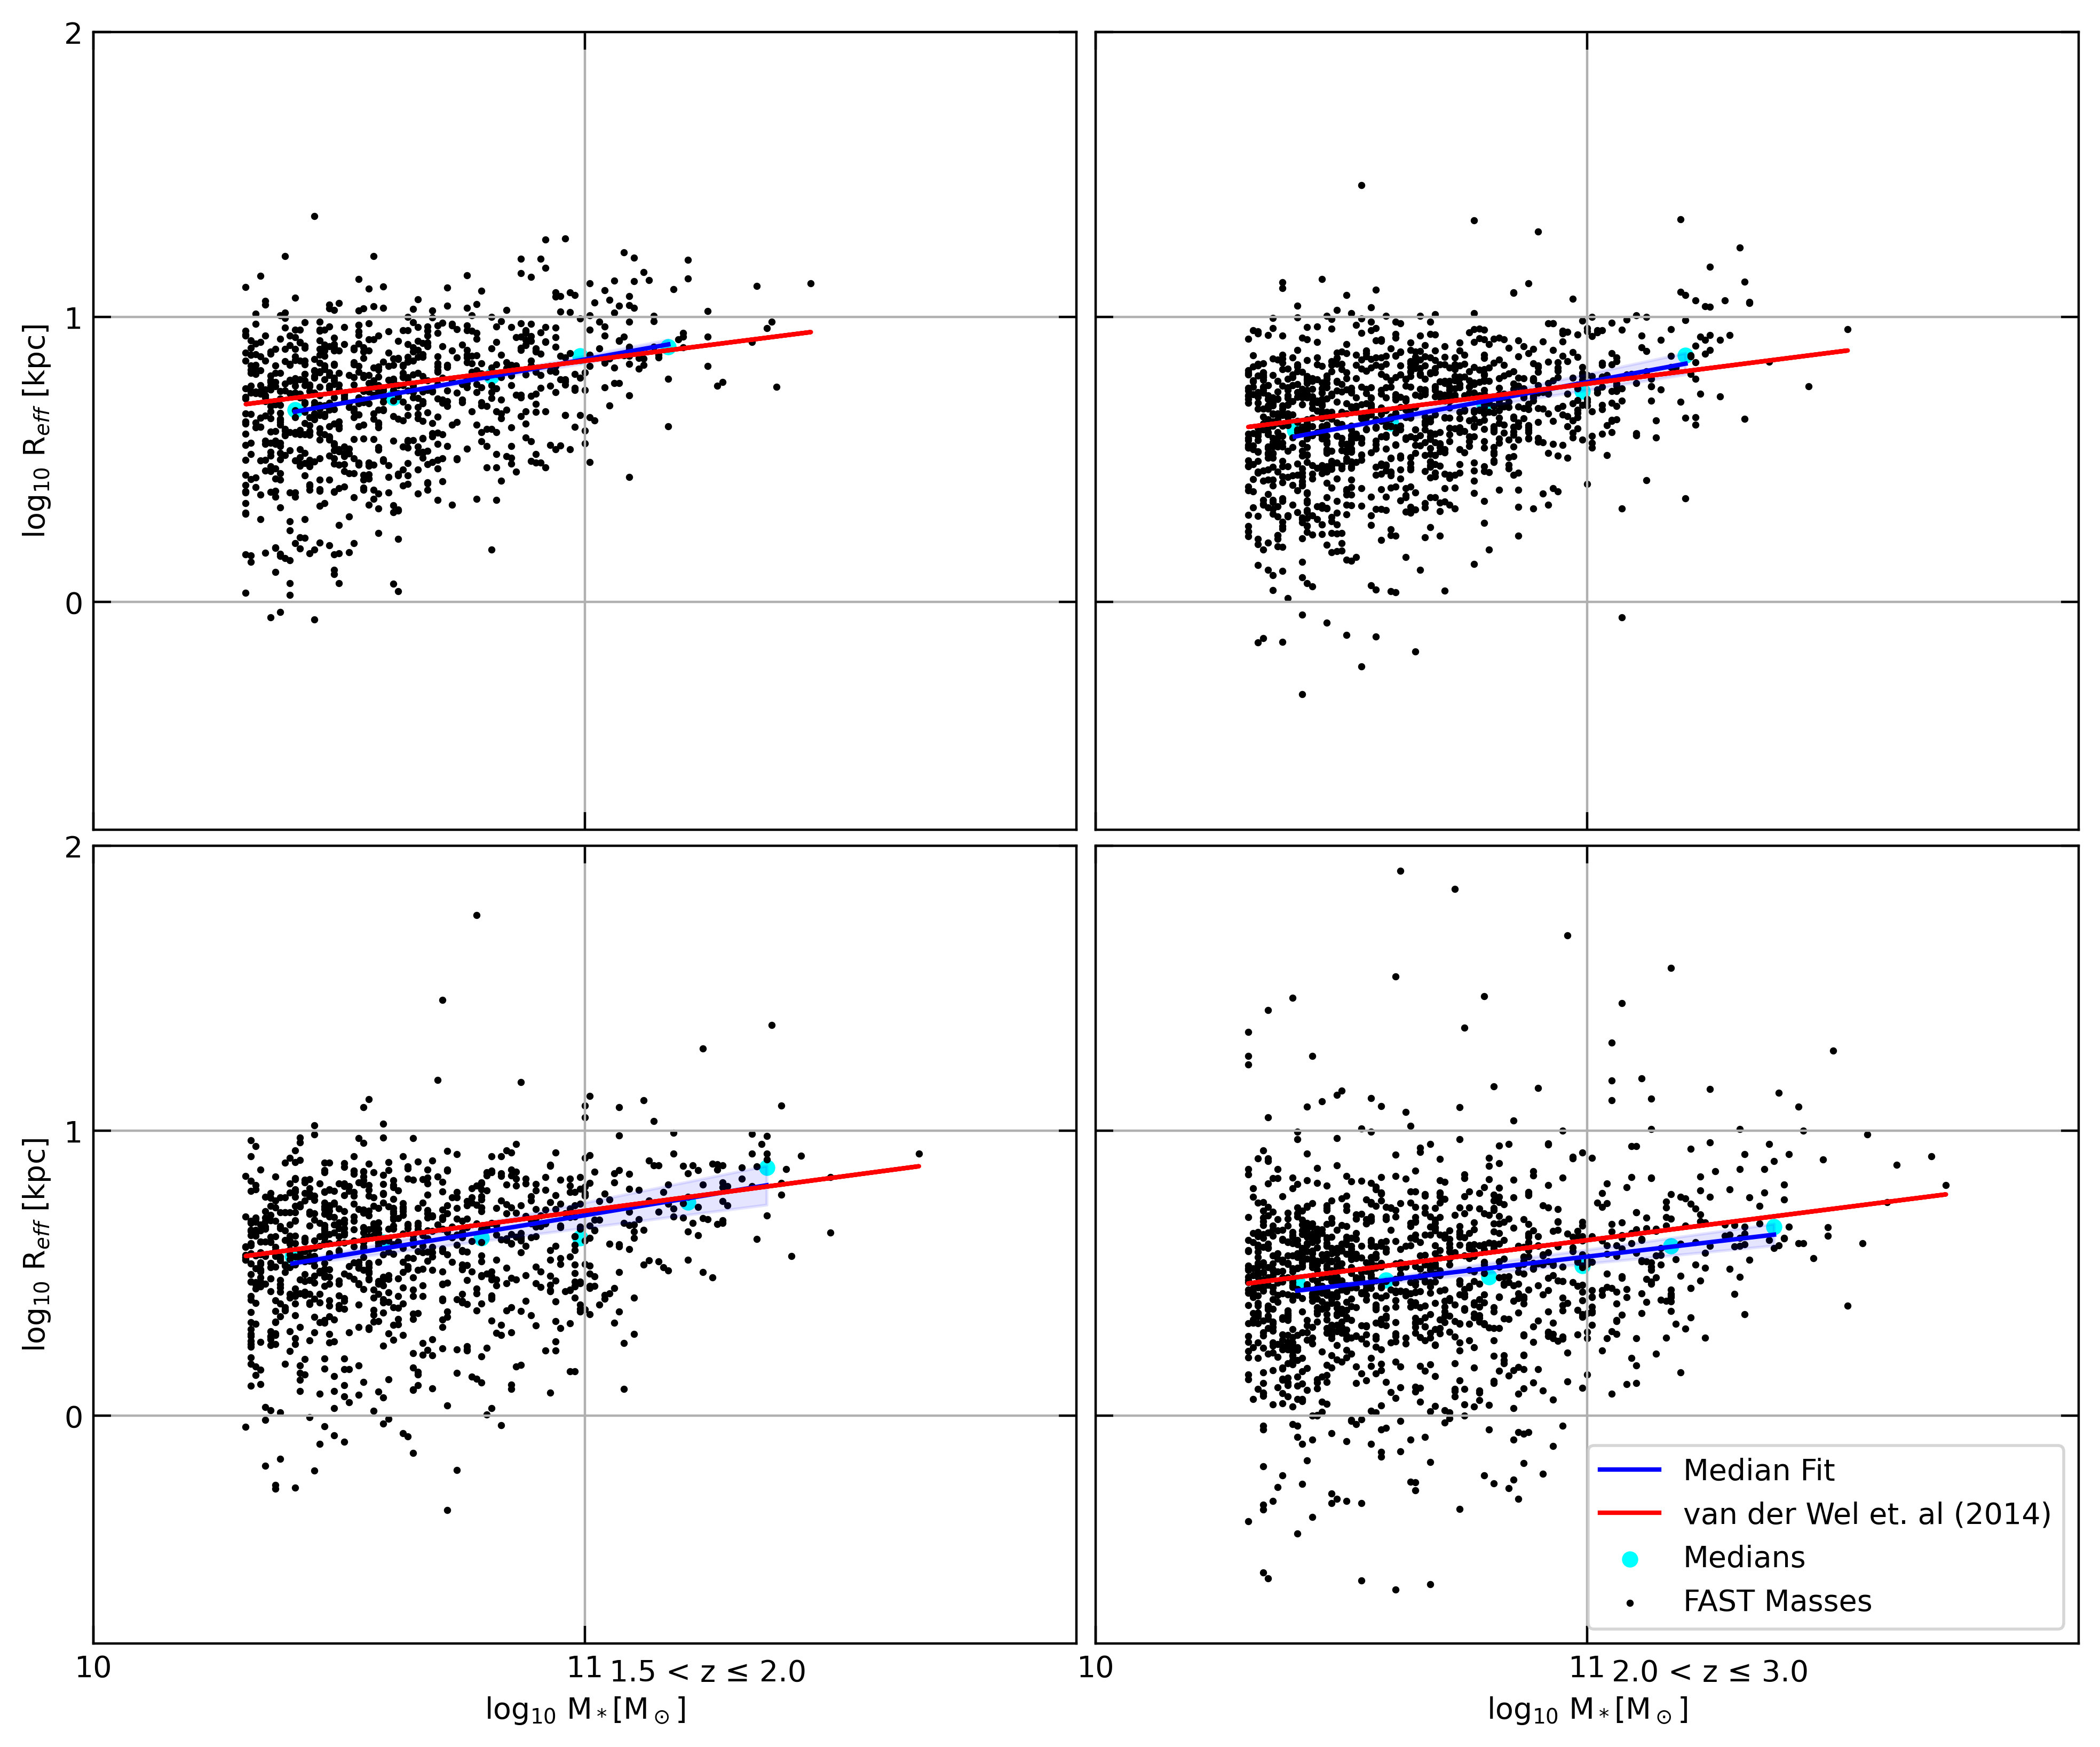

In [49]:
def power_law(M,A,a):
    return A+(a*M-a*np.log10(5e10))

def starforming_fit(xvals, yvals, error):   #curve fit calculation with upper fit and lower fit and comparison line
    fit_sf.append(curve_fit(f=power_law, xdata=xvals, ydata=yvals, sigma=error, p0=x0, bounds=bounds))
    highfit_sf.append(fit_sf[z][0]+np.sqrt(np.diag(fit_sf[z][1])))
    lowfit_sf.append(fit_sf[z][0]-np.sqrt(np.diag(fit_sf[z][1])))
    R_sf_fit.append(power_law(xvals,*fit_sf[z][0]))
    R_sf_comp.append(power_law(FAST_sf_vdw[z],Acomp[z],acomp[z]))
    R_sf_low.append(power_law(xvals,*lowfit_sf[z]))
    R_sf_high.append(power_law(xvals,*highfit_sf[z]))


#median calculation based on binsize and selection threshold
marray=np.arange(7.5,13,0.2)
M_medians = []
R_medians = []
R_medians_err = []

for z in range(4):
    mass_med = []
    radius_med = []
    radius_med_err = []
    for m in marray:
        sel=(FAST_sf_vdw[z]>m)&(FAST_sf_vdw[z]<m+0.2)    #mass selection
        #print(z,sum(sel))
        if sum(sel)>=10:
            mass_med.append(np.median(FAST_sf_vdw[z][sel]))  #adding mass medians for each selection
            radius_med.append(np.median(R_sf_vdw[z][sel]))   #adding radius medians for each selection
    mass_med = [i for i in mass_med if np.isnan(i) == False]  #removing nan values from median array
    mass_med = np.asarray(mass_med,dtype=object)
    radius_med = [i for i in radius_med if np.isnan(i) == False]  #removing nan values from median array
    radius_med = np.asarray(radius_med,dtype=object)
    M_medians.append(mass_med)
    R_medians.append(radius_med)
M_medians = np.asarray(M_medians,dtype=object)
R_medians = np.asarray(R_medians,dtype=object)
M_medians = [a.astype(np.float64) for a in M_medians]
R_medians = [a.astype(np.float64) for a in R_medians]
x0 =[0.3,0.75] #inital values of fit
bounds = ([-10,-10],[10,10]) #bounds of fit


#arrays in which the outputs of the fitting code will be sent
fit_sf = []
highfit_sf = []
lowfit_sf = []
R_sf_fit = []
R_sf_comp = []
R_sf_low = []
R_sf_high = []

Acomp = [0.78,0.7,0.65,0.55]  #A parameters from vdW
acomp = [0.22,0.22,0.23,0.22]  #alpha prameters from vdW

#fitting data
for z in range(4):
    starforming_fit(M_medians[z], R_medians[z], None)   #median weighted fit
    #starforming_fit(FAST_sf_vdw[z], R_sf_vdw[z], R_sf_vdw_err[z])  #error weighted fit

#plotting data
x = [0,0,1,1]
y = [0,1,0,1]
zlabels = ['0.5 ≤ z ≤ 1.0','1.0 < z ≤ 1.5','1.5 < z ≤ 2.0','2.0 < z ≤ 3.0']

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

for z in range(4):
    ax[x[z],y[z]].scatter(M_medians[z],R_medians[z],s=20,c='cyan', label='Medians')
    ax[x[z],y[z]].scatter(FAST_sf_vdw[z],R_sf_vdw[z],s=2,c='black',label='FAST Masses')
    ax[x[z],y[z]].plot(M_medians[z],R_sf_fit[z],c='blue',label='Median Fit')
    #ax[x[z],y[z]].plot(FAST_sf_vdw[z],R_sf_fit[z],c='blue',label='Error Weighted Fit')
    ax[x[z],y[z]].plot(FAST_sf_vdw[z],R_sf_comp[z],'',c='red',label='van der Wel et. al (2014)')
    #ax[x[z],y[z]].fill_between(FAST_sf_vdw[z],R_sf_low[z],R_sf_high[z],color='blue',alpha=0.1)
    ax[x[z],y[z]].fill_between(M_medians[z],R_sf_low[z],R_sf_high[z],color='blue',alpha=0.1)
    ax[x[z],y[z]].tick_params(which='major', direction='in', length=6)
    ax[x[z],y[z]].tick_params(which='minor', direction='in')
    if z == 0 or z == 2:
        ax[x[z],y[z]].set_yticks([-1,0,1,2])
    else:
        ax[x[z],y[z]].set_xticks([8,9,10,11])
    ax[x[z],y[z]].xaxis.set_ticks_position('both')
    ax[x[z],y[z]].yaxis.set_ticks_position('both')
    ax[x[z],y[z]].set_xlim(10,12)
    ax[x[z],y[z]].set_ylim(-0.8,2)
    ax[x[z],y[z]].text(11.05,-0.93,zlabels[z])
    if z==2 or z==3:
        ax[x[z],y[z]].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
    if z==0 or z==2:
        ax[x[z],y[z]].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')
    ax[x[z],y[z]].grid(True,'minor',alpha=0.1)
    ax[x[z],y[z]].grid()
    if z == 3:
        ax[x[z],y[z]].legend()

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

/var/folders/lv/vqqf9wvn2k71n_djgcvq2rg40000gn/T/ipykernel_24137/2211319240.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Frac = np.array(R_Error)/np.array(R)
/var/folders/lv/vqqf9wvn2k71n_djgcvq2rg40000gn/T/ipykernel_24137/2211319240.py:31: RuntimeWarning: invalid value encountered in log10
  sc = ax[x[z],y[z]].scatter(R[z],np.log10(Frac[z]),s=3, c=M[z], cmap='cma:laguna_r')


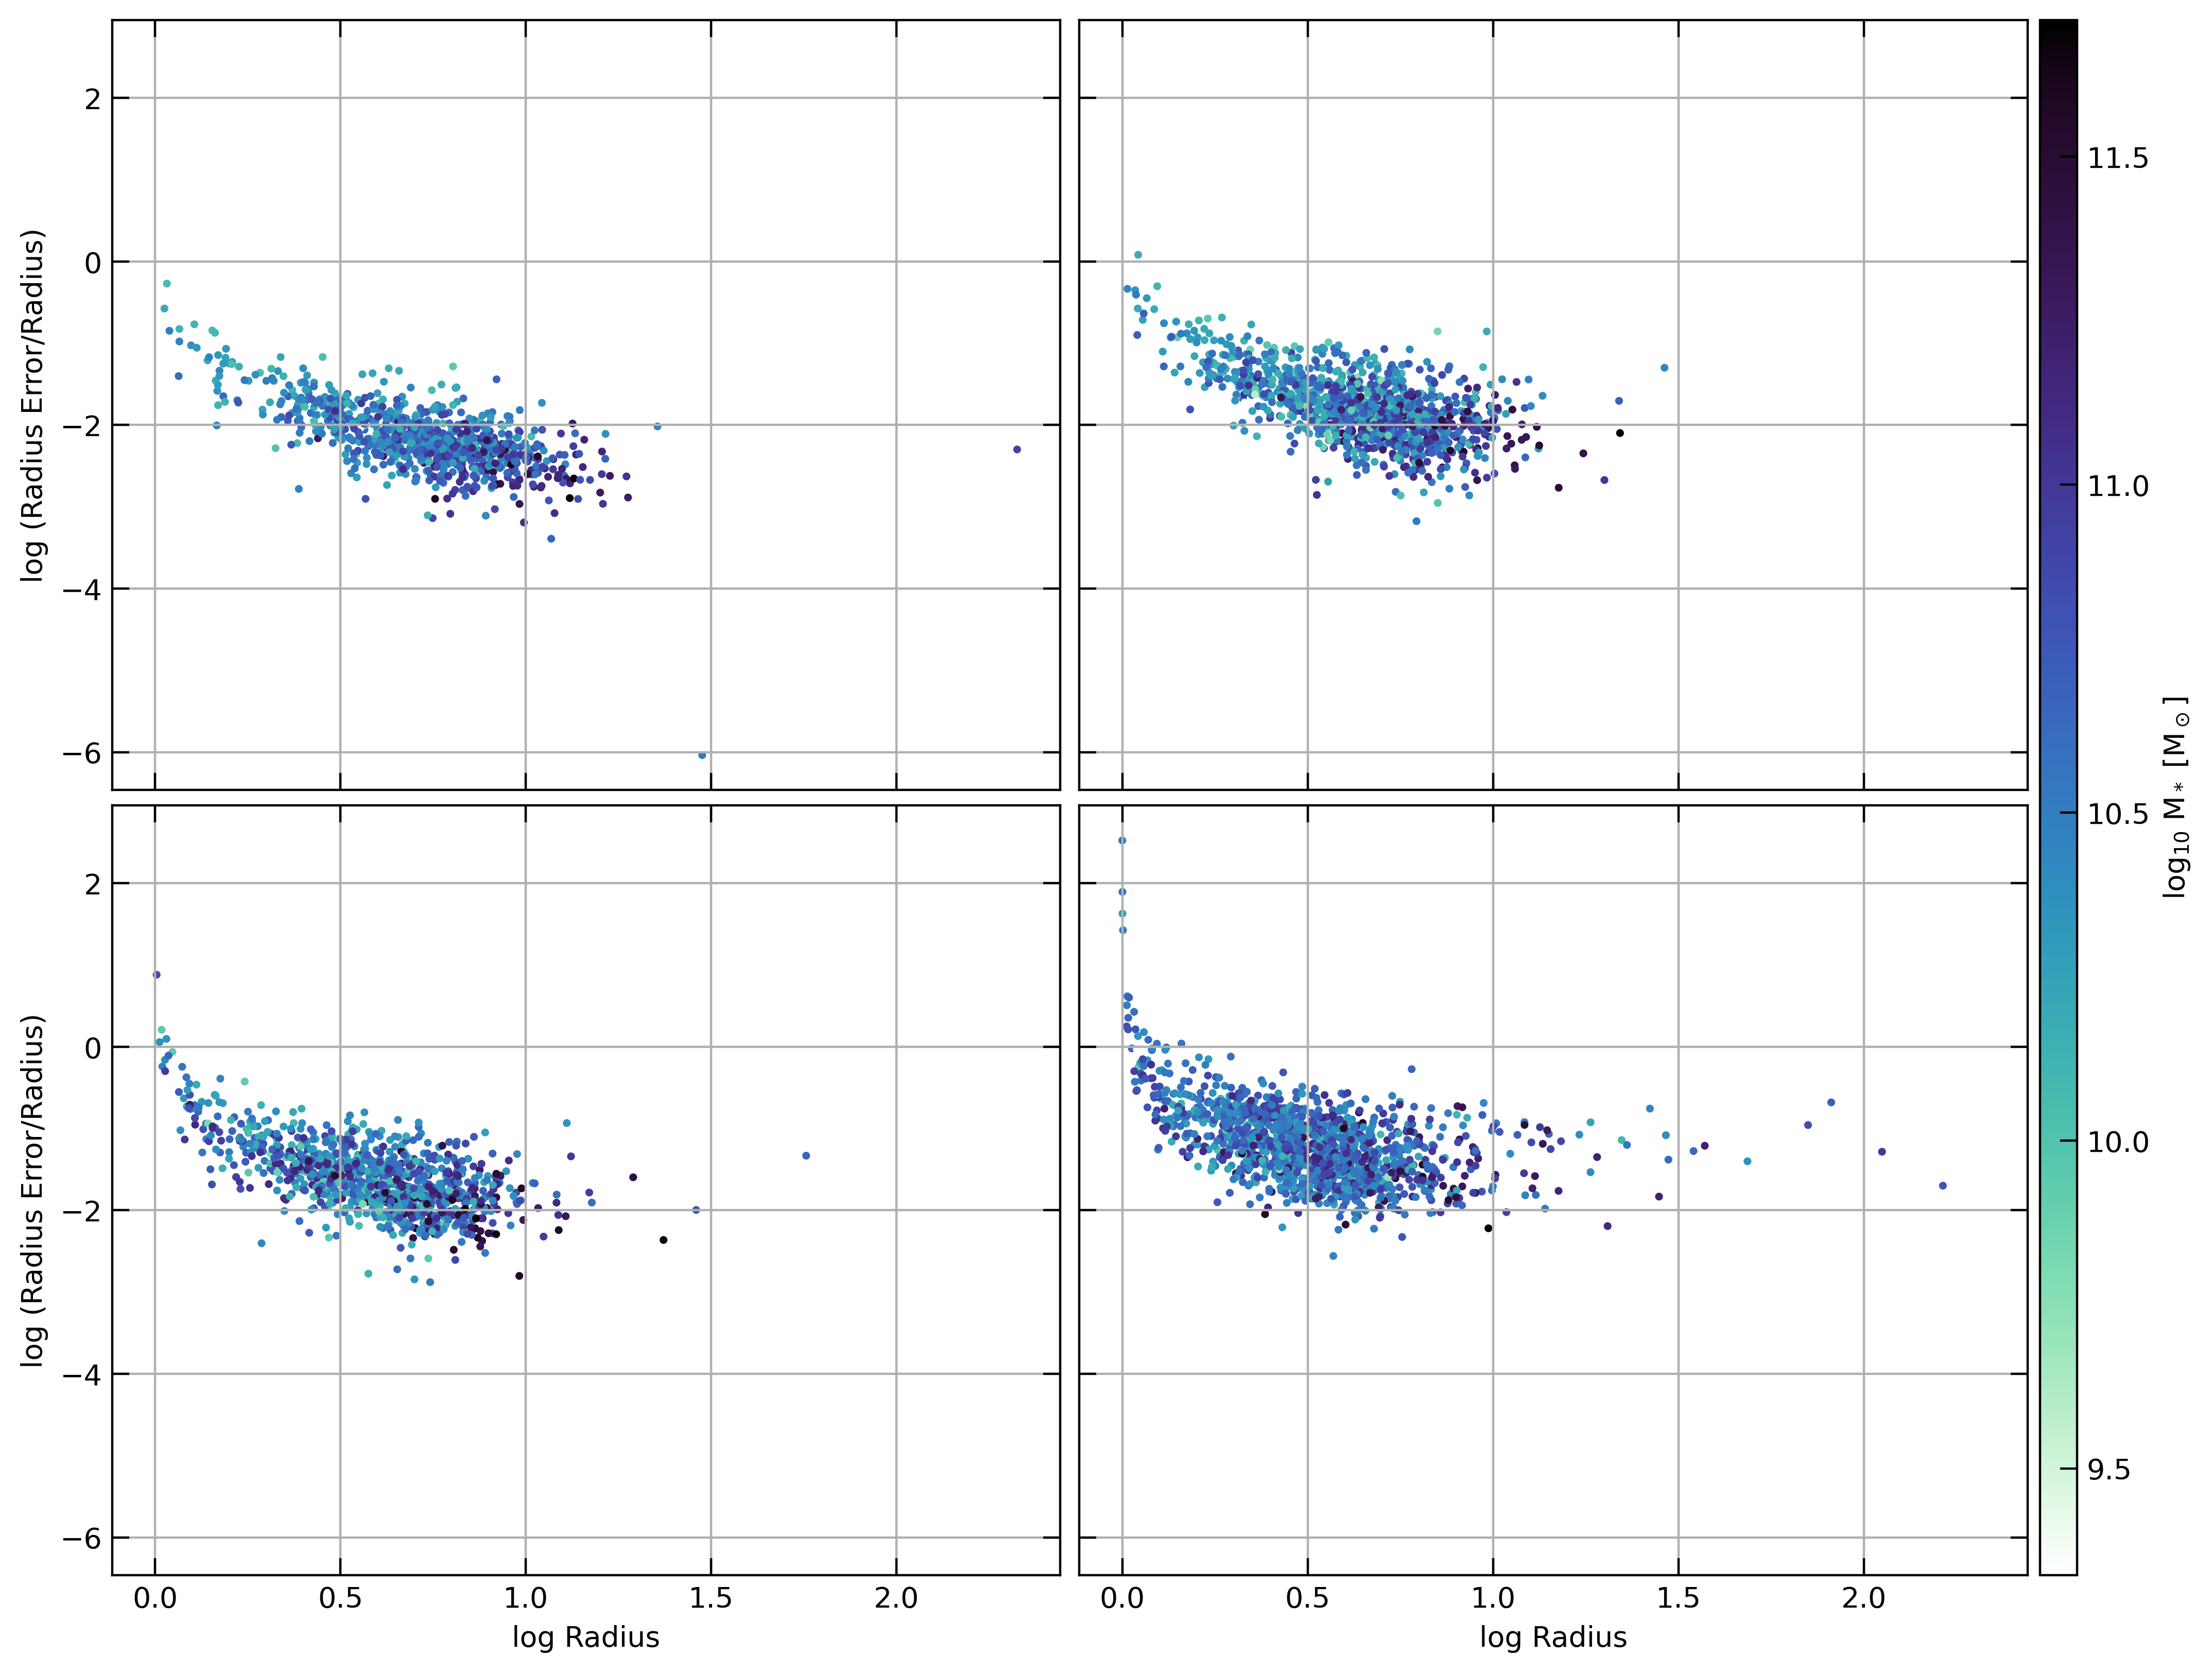

In [66]:
#Delta = np.array(M,dtype=object) - np.array(FAST,dtype=object)
R = []
R_Error= []
M = []

M.append(lmass[(redshift>=0.5)&(redshift<=1.0)&(starforming)&(FAST_lmass>10.301)])
M.append(lmass[(redshift>1.0)&(redshift<=1.5)&(starforming)&(FAST_lmass>10.301)])
M.append(lmass[(redshift>1.5)&(redshift<=2.0)&(starforming)&(FAST_lmass>10.301)])
M.append(lmass[(redshift>2)&(starforming)&(FAST_lmass>10.301)])

R.append(lR_eff[(redshift>=0.5)&(redshift<=1.0)&(starforming)&(FAST_lmass>10.301)])
R.append(lR_eff[(redshift>1.0)&(redshift<=1.5)&(starforming)&(FAST_lmass>10.301)])
R.append(lR_eff[(redshift>1.5)&(redshift<=2.0)&(starforming)&(FAST_lmass>10.301)])
R.append(lR_eff[(redshift>2)&(starforming)&(FAST_lmass>10.301)])

R_Error.append(lR_eff_err[(redshift<=1.0)&(starforming)&(FAST_lmass>10.301)])
R_Error.append(lR_eff_err[(redshift>1.0)&(redshift<=1.5)&(starforming)&(FAST_lmass>10.301)])
R_Error.append(lR_eff_err[(redshift>1.5)&(redshift<=2.0)&(starforming)&(FAST_lmass>10.301)])
R_Error.append(lR_eff_err[(redshift>2.0)&(starforming)&(FAST_lmass>10.301)])


Frac = np.array(R_Error)/np.array(R)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

x = [0,0,1,1]
y = [0,1,0,1]
zlabels = ['0.5 ≤ z ≤ 1.0','1.0 < z ≤ 1.5','1.5 < z ≤ 2.0','2.0 < z ≤ 3.0']

for z in range(len(R)):
    sc = ax[x[z],y[z]].scatter(R[z],np.log10(Frac[z]),s=3, c=M[z], cmap='cma:laguna_r')
    ax[x[z],y[z]].tick_params(which='major', direction='in', length=6)
    ax[x[z],y[z]].tick_params(which='minor', direction='in')
    ax[x[z],y[z]].xaxis.set_ticks_position('both')
    ax[x[z],y[z]].yaxis.set_ticks_position('both')
    if z==2 or z==3:
        ax[x[z],y[z]].set_xlabel('log Radius')
    if z==0 or z==2:
        ax[x[z],y[z]].set_ylabel('log (Radius Error/Radius)')
    ax[x[z],y[z]].grid(True,'minor',alpha=0.1)
    ax[x[z],y[z]].grid()

plt.subplots_adjust(wspace=0.02, hspace=0.02)

cbar_ax = fig.add_axes([0.905, 0.125, 0.015, 0.755])
cbar = fig.colorbar(sc, cax=cbar_ax)

cbar
cbar.ax.set_ylabel('log$_{10}$ M$_*$ [M$_\odot$]')
cbar.ax.tick_params(direction='in', length=6)

plt.gcf().set_size_inches(12, 10)

plt.show()

In [60]:
marray=np.arange(8.5,13,0.2)
rarray=np.arange(-1,3,0.2)
M_medians_sf = []
R_medians_sf = []
FAST_medians_sf = []


for z in range(4):
    mass_med = []
    fast_med = []
    radius_med = []
    for m in marray:
        for r in rarray:
            sel=(FAST_sf[z]>=m)&(FAST_sf[z]<m+0.2)&(R_sf[z]>=r)&(R_sf[z]<r+0.2)
            if sum(sel)>=10:
                box_masses = M_sf[z][sel]
                box_fast = FAST_sf[z][sel]
                box_radii = R_sf[z][sel]+np.random.normal(scale=0.03)
                mass_med.append(np.median(box_masses))
                fast_med.append(np.median(box_fast))
                radius_med.append(np.median(box_radii))
    mass_med = [i for i in mass_med if np.isnan(i) == False]
    mass_med = np.asarray(mass_med,dtype=object)
    fast_med = [i for i in fast_med if np.isnan(i) == False]
    fast_med = np.asarray(fast_med,dtype=object)
    radius_med = [i for i in radius_med if np.isnan(i) == False]
    radius_med = np.asarray(radius_med,dtype=object)
    M_medians_sf.append(mass_med)
    FAST_medians_sf.append(fast_med)
    R_medians_sf.append(radius_med)

Med_Delta_sf = np.array(M_medians_sf,dtype=object)-np.array(FAST_medians_sf,dtype=object)
RMed_Delta_sf = np.array(R_medians_sf,dtype=object)-np.array(R_medians_sf,dtype=object)
Med_Delta_sf = [a.astype(np.float64) for a in Med_Delta_sf]
RMed_Delta_sf = [a.astype(np.float64) for a in RMed_Delta_sf]
FAST_medians_sf = [a.astype(np.float64) for a in FAST_medians_sf]
R_medians_sf = [a.astype(np.float64) for a in R_medians_sf]
M_medians_sf = [a.astype(np.float64) for a in M_medians_sf]
         
carray=np.arange(8.5,13,0.3)
mass_sf = [[],[],[],[]]
frac_sf = [[],[],[],[]]
for i in range(len(M_sf)):
    for c in marray:
        sel=(M_sf[i]>c)&(M_sf[i]<c+0.3)
        if sum(sel)!= 0:
            mass_sf[i].append(c+0.3)
            frac_sf[i].append(len(M_sf[i][(sel)&(mag_sf[i]<24.5)])/len(M_sf[i][sel]))

In [47]:
marray=np.arange(8.5,13,0.2)
rarray=np.arange(-1,3,0.2)
M_medians_q = []
R_medians_q = []
FAST_medians_q = []

for z in range(4):
    mass_med = []
    fast_med = []
    radius_med = []
    for m in marray:
        for r in rarray:
            sel=(FAST_q[z]>=m)&(FAST_q[z]<m+0.2)&(R_q[z]>=r)&(R_q[z]<r+0.2)
            if sum(sel)>=5:
                box_masses = M_q[z][sel]
                box_fast = FAST_q[z][sel]
                box_radii = R_q[z][sel]+np.random.normal()
                mass_med.append(np.median(box_masses))
                fast_med.append(np.median(box_fast))
                radius_med.append(np.median(box_radii))
    mass_med = [i for i in mass_med if np.isnan(i) == False]
    mass_med = np.asarray(mass_med,dtype=object)
    fast_med = [i for i in fast_med if np.isnan(i) == False]
    fast_med = np.asarray(fast_med,dtype=object)
    radius_med = [i for i in radius_med if np.isnan(i) == False]
    radius_med = np.asarray(radius_med,dtype=object)
    M_medians_q.append(mass_med)
    FAST_medians_q.append(fast_med)
    R_medians_q.append(radius_med)

Med_Delta_q = np.array(M_medians_q,dtype=object)-np.array(FAST_medians_q,dtype=object)
RMed_Delta_q = np.array(R_medians_q,dtype=object)-np.array(R_medians_q,dtype=object)
Med_Delta_q = [a.astype(np.float64) for a in Med_Delta_q]
RMed_Delta_q = [a.astype(np.float64) for a in RMed_Delta_q]
FAST_medians_q = [a.astype(np.float64) for a in FAST_medians_q]
R_medians_q = [a.astype(np.float64) for a in R_medians_q]
M_medians_q = [a.astype(np.float64) for a in M_medians_q]

carray=np.arange(8.5,13,0.3)
mass_q = [[],[],[],[]]
frac_q = [[],[],[],[]]
for i in range(len(M_q)):
    for c in marray:
        sel=(M_q[i]>c)&(M_q[i]<c+0.3)
        if sum(sel)!= 0:
            mass_q[i].append(c+0.3)
            frac_q[i].append(len(M_q[i][(sel)&(mag_q[i]<24.5)])/len(M_q[i][sel]))

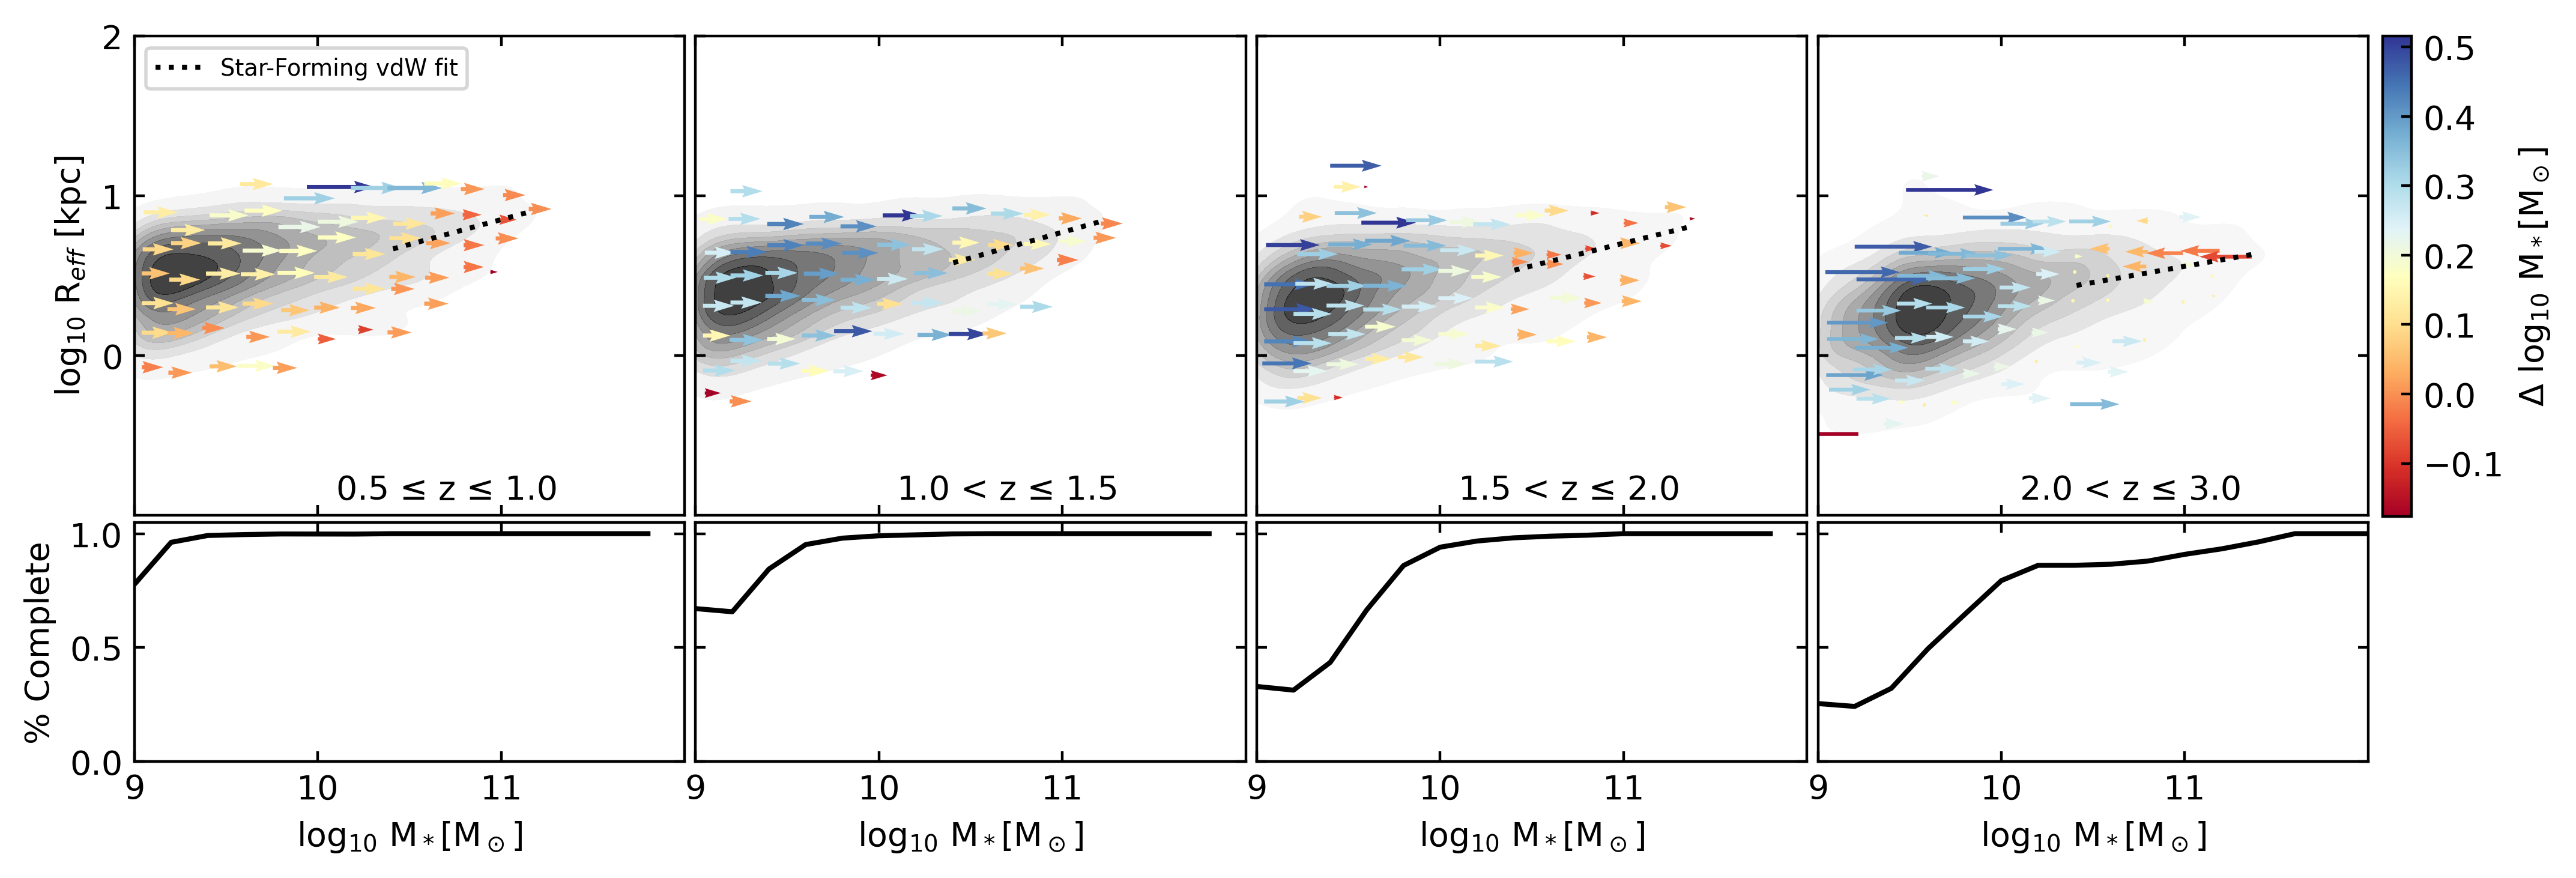

In [68]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    #plt.register_cmap(cmap=newcmap)

    return newcmap

fig, ax = plt.subplots(2, 4, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

x = [0,0,0,0]
x2 = [1,1,1,1]
y = [0,1,2,3]
zlabels = ['0.5 ≤ z ≤ 1.0','1.0 < z ≤ 1.5','1.5 < z ≤ 2.0','2.0 < z ≤ 3.0']


map1 = plt.cm.Reds_r(np.linspace(0., 1, 128))
map2 = plt.get_cmap(name='cma:laguna_r')(np.linspace(0, 1, 128))

# combine them and build a new colormap
comb_map = np.vstack((map1, map2))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', comb_map)
#cmap = shiftedColorMap(mymap, midpoint=0.24)
cmap = plt.cm.RdYlBu
cNorm  = colors.Normalize(vmin=min(min(x) for x in Med_Delta_sf), vmax=max(max(x) for x in Med_Delta_sf))
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)

levels=[.1,.2,.3,.4,.6,.7,.8,.9,1]

for z in range(4):
    sbrn.kdeplot(x=FAST_sf[z], y=R_sf[z], shade=True, cmap='binary', ax=ax[x[z],y[z]], alpha=0.8)#, levels=levels)
    #if z==0:
    #    ax[x[z],y[z]].plot(FAST_sf_vdw[z],model,':',c='black',label='Star-Forming vdW fit')
    ax[x[z],y[z]].plot(M_medians[z],R_sf_fit[z],':',c='black',label='Star-Forming vdW fit')
    ax[x[z],y[z]].quiver(FAST_medians_sf[z], R_medians_sf[z], Med_Delta_sf[z], RMed_Delta_sf[z], Med_Delta_sf[z], cmap=cmap)
    ax[x[z],y[z]].tick_params(which='major', direction='in', length=3)
    ax[x[z],y[z]].tick_params(which='minor', direction='in', length=1)
    ax[x[z],y[z]].set_yticks([0,1,2])
    ax[x[z],y[z]].set_xticks([9,10,11])
    if z > 0:
        ax[x[z],y[z]].set_yticklabels([])
    ax[x[z],y[z]].xaxis.set_ticks_position('both')
    ax[x[z],y[z]].yaxis.set_ticks_position('both')
    ax[x[z],y[z]].set_xlim(9,12)
    ax[x[z],y[z]].set_ylim(-1,2)
    #ax[x[z],y[z]].set_yscale('log')
    ax[x[z],y[z]].text(10.1,-0.9,zlabels[z])
    if z==2 or z==3:
        ax[x[z],y[z]].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
    if z==0:
        ax[x[z],y[z]].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')
    if z == 0:
        ax[x[z],y[z]].legend(fontsize='x-small', loc='upper left')

for z in range(4):
    ax[x2[z],y[z]].plot(mass_sf[z],frac_sf[z],c='black')
    ax[x2[z],y[z]].set_ylim(0,1.05)
    if z > 0:
        ax[x2[z],y[z]].set_yticklabels([])
    ax[x2[z],y[z]].tick_params(which='major', direction='in', length=3)
    ax[x2[z],y[z]].tick_params(which='minor', direction='in')
    ax[x2[z],y[z]].xaxis.set_ticks_position('both')
    ax[x2[z],y[z]].yaxis.set_ticks_position('both')
    ax[x2[z],y[z]].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
    if z==0:
        ax[x2[z],y[z]].set_ylabel('% Complete')
    ax[x2[z],y[z]].grid(True,'minor',alpha=0.1)
    
    
cbar_ax = fig.add_axes([0.905, 0.380, 0.010, 0.500])

cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=cNorm, orientation='vertical')
cb1.ax.set_ylabel('$\Delta$ log$_{10}$ M$_*$[M$_\odot$]')
cb1.ax.tick_params(direction='in', length=3)

plt.gcf().set_size_inches(12, 4)
plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

In [ ]:
fig, ax = plt.subplots(2, 4, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

x = [0,0,0,0]
x2 = [1,1,1,1]
y = [0,1,2,3]
zlabels = ['0.5 ≤ z ≤ 1.0','1.0 < z ≤ 1.5','1.5 < z ≤ 2.0','2.0 < z ≤ 3.0']


map1 = plt.cm.Reds_r(np.linspace(0., 1, 128))
map2 = plt.get_cmap(name='cma:laguna_r')(np.linspace(0, 1, 128))

# combine them and build a new colormap
comb_map = np.vstack((map1, map2))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', comb_map)
cmap = shiftedColorMap(mymap, midpoint=0.22)
#cmap = 'RdYlBu'
cNorm  = colors.Normalize(vmin=min(min(x) for x in Med_Delta_q), vmax=max(max(x) for x in Med_Delta_q))
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)

levels=[.1,.2,.3,.4,.6,.7,.8,.9,1]

for z in range(4):
    sbrn.kdeplot(x=FAST_q[z], y=R_q[z], shade=True, cmap='binary', ax=ax[x[z],y[z]], alpha=0.8)#, levels=levels)
    #ax[x[z],y[z]].scatter(FAST_q[z],R_q[z],s=0.5,c='grey',label='FAST Masses')
    ax[x[z],y[z]].plot(FAST_q_vdw[z],R_q_fit[z],':',c='black',label='Quiescent vdW fit')
    ax[x[z],y[z]].quiver(FAST_medians_q[z], R_medians_q[z], Med_Delta_q[z], RMed_Delta_q[z], Med_Delta_q[z], cmap=cmap)
    ax[x[z],y[z]].tick_params(which='major', direction='in', length=3)
    ax[x[z],y[z]].tick_params(which='minor', direction='in', length=1)
    ax[x[z],y[z]].set_yticks([0,1,2])
    ax[x[z],y[z]].set_xticks([9,10,11])
    if z > 0:
        ax[x[z],y[z]].set_yticklabels([])
    ax[x[z],y[z]].xaxis.set_ticks_position('both')
    ax[x[z],y[z]].yaxis.set_ticks_position('both')
    ax[x[z],y[z]].set_xlim(9,12)
    ax[x[z],y[z]].set_ylim(-1,2)
    #ax[x[z],y[z]].set_yscale('log')
    ax[x[z],y[z]].text(10.1,-0.9,zlabels[z])
    if z==2 or z==3:
        ax[x[z],y[z]].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
    if z==0:
        ax[x[z],y[z]].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')
    ax[x[z],y[z]].grid(True,'minor',alpha=0.5)
    #ax[x[z],y[z]].grid()
    if z == 0:
        ax[x[z],y[z]].legend(fontsize='x-small', loc='upper left')

for z in range(4):
    ax[x2[z],y[z]].plot(mass_q[z],frac_q[z],c='black')
    ax[x2[z],y[z]].set_ylim(0,1.05)
    if z > 0:
        ax[x2[z],y[z]].set_yticklabels([])
    ax[x2[z],y[z]].tick_params(which='major', direction='in', length=3)
    ax[x2[z],y[z]].tick_params(which='minor', direction='in')
    ax[x2[z],y[z]].xaxis.set_ticks_position('both')
    ax[x2[z],y[z]].yaxis.set_ticks_position('both')
    ax[x2[z],y[z]].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
    if z==0:
        ax[x2[z],y[z]].set_ylabel('% Complete')
    ax[x2[z],y[z]].grid(True,'minor',alpha=0.1)
    
    
cbar_ax = fig.add_axes([0.905, 0.380, 0.010, 0.500])
#cbar_ax = fig.add_axes([0.905, 0.125, 0.015, 0.755])
#cbar = fig.colorbar(sc, cax=cbar_ax)

#cbar
#cbar.ax.set_ylabel('log$_{10}$ sSFR [yr$^{-1}$]')
#cbar.ax.tick_params(direction='in', length=6)

cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=cNorm, orientation='vertical')
cb1.ax.set_ylabel('$\Delta$ log$_{10}$ M$_*$[M$_\odot$]')
cb1.ax.tick_params(direction='in', length=3)

plt.gcf().set_size_inches(12, 4)
plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()